# Progetto di Machine Learning 2023

Il presente progetto riguarda la predizione dei prezzi delle case.

In [96]:
from feature_selection import *
from model_selection import *
from models import *
from grafici import *
from dataset import *
import pandas as pd
import numpy as np
import seaborn as sns
from typing import List, Tuple, Dict

plots = Grafici()


In [97]:
from sklearn.model_selection import train_test_split


initial_training_set = pd.read_csv('../dataset/train.csv')

initial_X = initial_training_set.iloc[:, 1:-1] # tutte le colonne tranne l'ultima
initial_y = initial_training_set.iloc[:, -1] # solo l'ultima colonna

In [98]:
initial_training_set.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

Suddividiamo il training e il testing set

# 1. Data cleaning
Analizziamo il dataset per eliminare i valori nulli. In particolare adottiamo la seguente politica:
- se i valori nulli sono maggiori del 80% degli elementi del training set, eliminiamo la feature.
- altrimenti, se la feature è numerica, sostituiamo il valore nullo con il valore medio.
- altrimenti, se la feature è categorica, sostituiamo il valore nullo con il valore più comune.

Questo passaggio è necessario per il corretto funzionamento dei metodi di feature selection, feature extraction e per i modelli di machine learning che utilizzeremo.

## Rimozione delle colonne con molti valori nulli
Innanzitutto realizziamo un grafico con le features che hanno almeno un valore nullo:

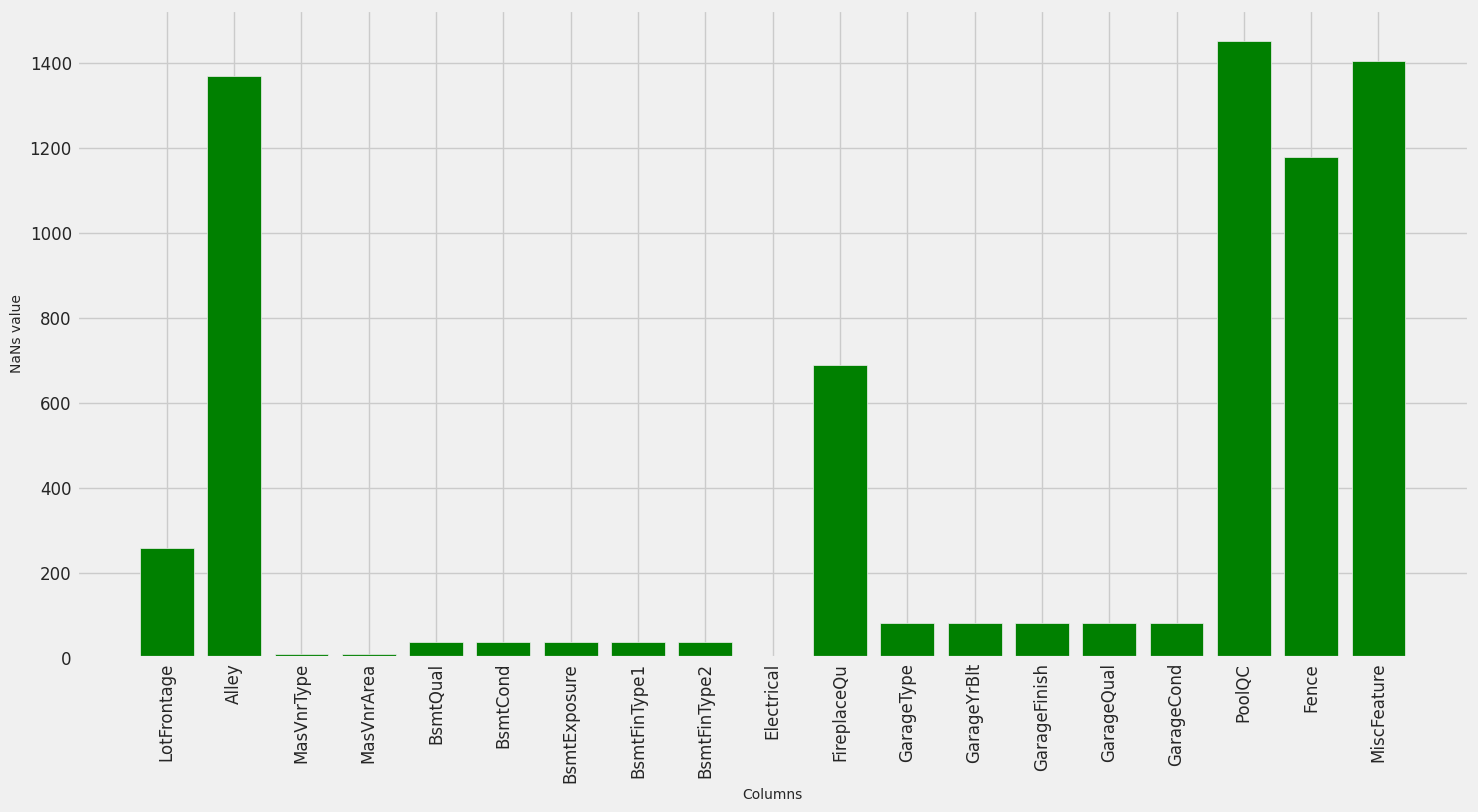

Colonne con valori nulli:  19


In [99]:
def get_nan_cols(dataset: pd.DataFrame) -> Tuple[pd.DataFrame, pd.Index]:
    """ Restituisce:
        0: un dataframe con nome colonna, numero null
        1: una lista (Index) con i nomi delle colonne che hanno valori nulli
    """
    count_nan = dataset.isnull().sum(axis=0)
    columns_with_nan_df = count_nan.loc[count_nan != 0]
    nan_cols_names = dataset.columns[dataset.isna().any()]
    return columns_with_nan_df, nan_cols_names

def get_cols_with_nan_number(dataset: pd.DataFrame) -> int:
    print("Colonne con valori nulli: ", len(get_nan_cols(dataset)[1].to_list()))

def check_nan_value(dataset):
    # Verifichiamo se ci sono valori NaN
    columns_with_nan_df, nan_cols_names = get_nan_cols(dataset)
    pd.DataFrame(data=nan_cols_names)
    plt.figure(figsize=(16,8))
    plt.bar(nan_cols_names, columns_with_nan_df, color="green")
    plt.xlabel("Columns")
    plt.xticks(rotation=90)
    plt.ylabel("NaNs value")
    plt.show()

check_nan_value(initial_training_set)
get_cols_with_nan_number(initial_training_set)

Notiamo che ci sono 19 colonne che hanno almeno un valore nullo. In particolare: **Alley**, **PoolQC**, **Fence** e **MiscFeature** hanno più dell'85% di valori nulli, quindi le **eliminiamo**

Numero di valori non nulli minimo:  293


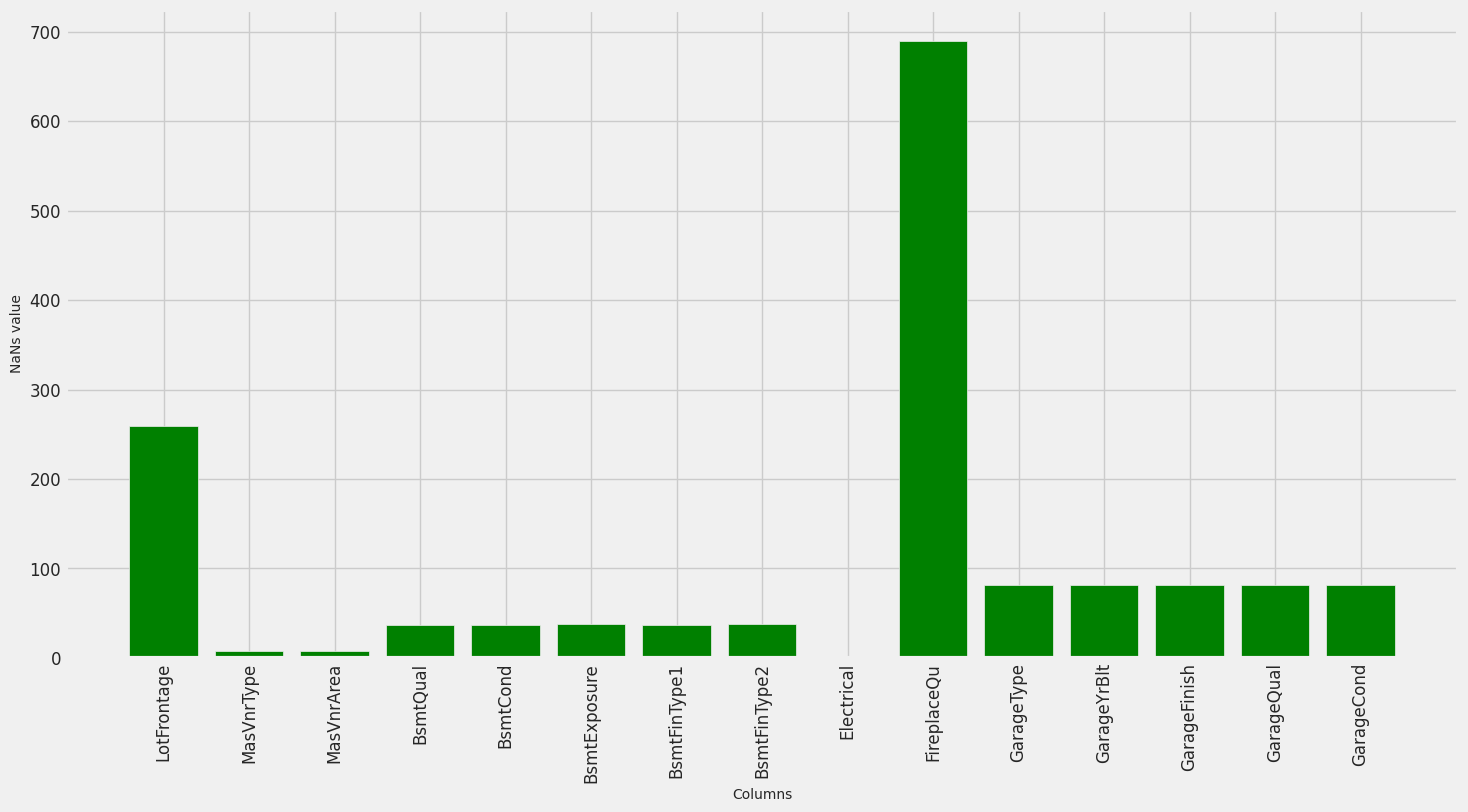

Colonne con valori nulli:  15


In [100]:
def remove_nan_columns(dataset: DataFrame, threshold=20) -> DataFrame:
        """Elimina colonne con valori NaN quando i valori Nan sono superiori a [threshold]%"""
        thresh = int((len(dataset) * threshold) / 100) + 1
        print("Numero di valori non nulli minimo: ", thresh)
        # axis: specifichiamo di eliminare solo le colonne; thresh: numero minimo per eliminare
        dataset.dropna(axis='columns', thresh=thresh, inplace=True)
        return dataset

initial_training_set2 =  remove_nan_columns(initial_training_set)
check_nan_value(initial_training_set2) # senza troppi valori nulli
get_cols_with_nan_number(initial_training_set2)

## Sostituzione dei valori nulli nelle feature numeriche

Per prima cosa prendiamo le feature numeriche

In [101]:
numerical_cols = initial_training_set2.select_dtypes(include='number').columns.to_list()
numerical_train = initial_training_set2[numerical_cols]
print(numerical_cols)

['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice']


Sostituiamo alle colonne numeriche del training set `initial_training_set2` a cui abbiamo eliminato le colonne con oltre l'80% dei valori nulli, la media dei valori al posto dei rimanenti valori NaN

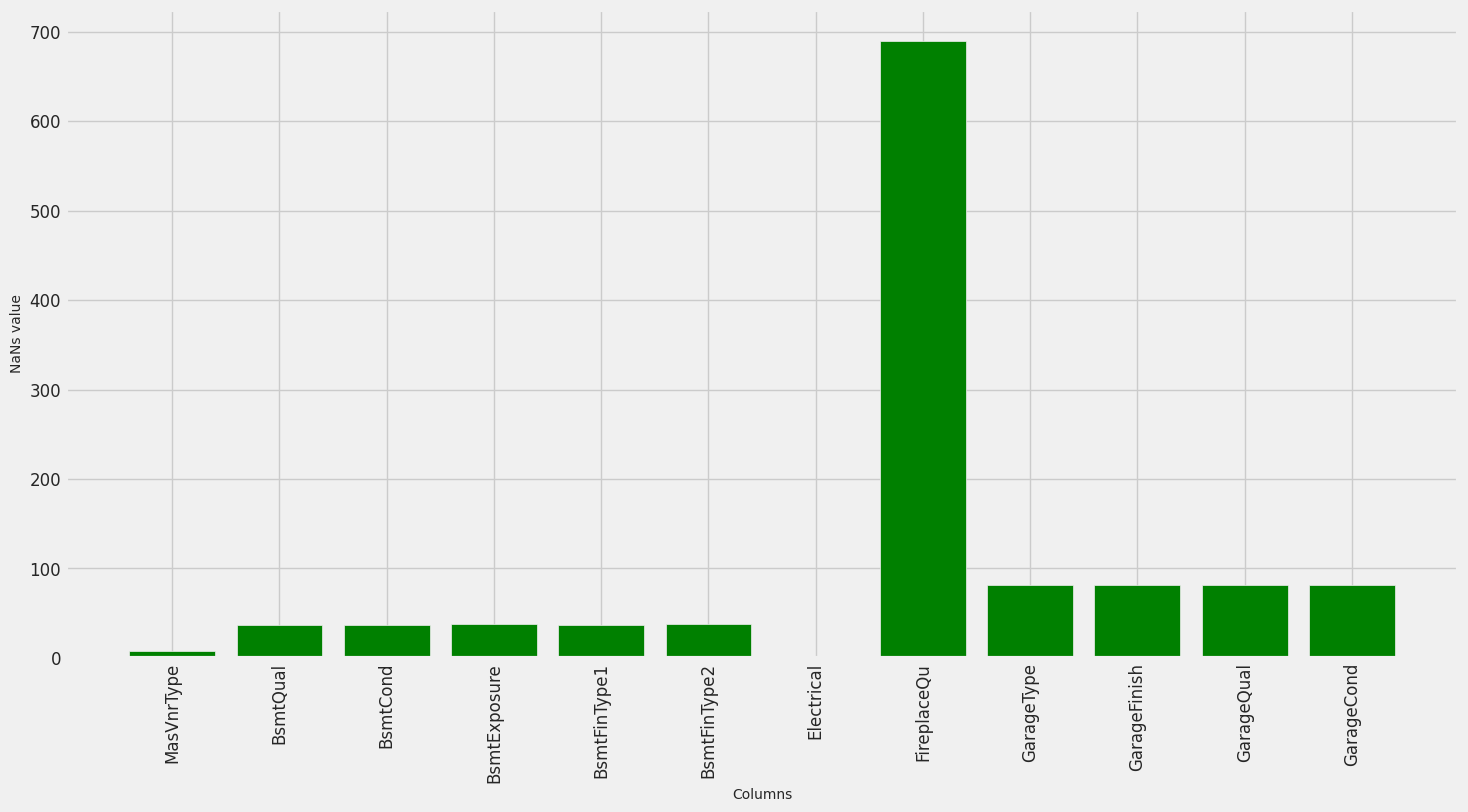

Colonne con valori nulli:  12


In [102]:
initial_training_set2 = initial_training_set2.fillna(initial_training_set2[numerical_cols].mean())
check_nan_value(initial_training_set2) # senza troppi valori nulli
get_cols_with_nan_number(initial_training_set2)

## Sostituzione dei valori nulli nelle feature categoriche

Per prima cosa prendiamo le colonne categoriche

In [103]:
categorical_cols = initial_training_set2.select_dtypes(include='object').columns.to_list()
categorical_train = initial_training_set2[categorical_cols]
print(categorical_cols)

['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition']


Sostituiamo alle colonne **categoriche** del training set `initial_training_set2` a cui abbiamo eliminato le colonne con oltre l'80% dei valori nulli e i valori nulli delle colonne numeriche, la moda dei valori al posto dei rimanenti valori NaN.

In [104]:
mode = categorical_train.mode()
print("Valori più frequenti", mode.iloc[0], "\n\n")
initial_training_set2 = initial_training_set2.fillna(mode.iloc[0])
get_cols_with_nan_number(initial_training_set2)

Valori più frequenti MSZoning              RL
Street              Pave
LotShape             Reg
LandContour          Lvl
Utilities         AllPub
LotConfig         Inside
LandSlope            Gtl
Neighborhood       NAmes
Condition1          Norm
Condition2          Norm
BldgType            1Fam
HouseStyle        1Story
RoofStyle          Gable
RoofMatl         CompShg
Exterior1st      VinylSd
Exterior2nd      VinylSd
MasVnrType          None
ExterQual             TA
ExterCond             TA
Foundation         PConc
BsmtQual              TA
BsmtCond              TA
BsmtExposure          No
BsmtFinType1         Unf
BsmtFinType2         Unf
Heating             GasA
HeatingQC             Ex
CentralAir             Y
Electrical         SBrkr
KitchenQual           TA
Functional           Typ
FireplaceQu           Gd
GarageType        Attchd
GarageFinish         Unf
GarageQual            TA
GarageCond            TA
PavedDrive             Y
SaleType              WD
SaleCondition     Normal
Name

# Preprocessing
Trasformiamo tutte le colonne categoriche in numeriche.
- Se la colonna categorica rappresenta una valutazione, usiamo l'ordinal encoding
- Altrimenti usiamo one-hot encoding (one-of-k). In tal caso le feature aumenteranno quindi bisogna controllare il numero di colonne finale.

Per prima cosa determiniamo le colonne categoriche che vanno trasformate con l'**ordinal encoding** e quelle che vanno trasformate con l'one hot encoding, a partire dal file `valutazioneFeature.csv`.

In [105]:
ordinal_enc_cols = [
    "ExterQual",
    "KitchenQual",
    "ExterCond",
    "HeatingQC",
    "BsmtCond",
    "BsmtFinType1",
    "BsmtFinType2",
    "GarageCond",
    "BsmtExposure",
    "GarageQual",
    "FireplaceQu",
    "BsmtQual"
]

onehot_enc_cols = [
    "MSZoning",
    "Condition1",
    "Electrical",
    "Functional",
    "Utilities",
    "Condition2",
    "Exterior1st",
    "BldgType",
    "CentralAir",
    "Exterior2nd",
    "Heating",
    "HouseStyle",
    "MSSubClass",
    "RoofMatl",
    "Street",
    "LotConfig",
    "Neighborhood",
    "LandSlope",
    "Foundation",
    "LandContour",
    "MasVnrType",
    "PavedDrive",
    "RoofStyle",
    "SaleType",
    "GarageFinish",
    "GarageType",
    "LotShape",
    "SaleCondition"
]

Eseguiamo prima l'ordinal encoding:

In [110]:
def ordinal_encoding(dataset: DataFrame, ord_enc_cols: List[str]) -> DataFrame:
        # applica l'ordinal Encoding alle colonne categoriche che rappresentano una valutazione
        copy = dataset.copy()
        for cat in ord_enc_cols:
            copy[cat], _ = pd.factorize(dataset[cat])

        return copy

initial_training_set3 = ordinal_encoding(initial_training_set2, ordinal_enc_cols)

     ExterQual KitchenQual ExterCond HeatingQC BsmtCond BsmtFinType1  \
0           Gd          Gd        TA        Ex       TA          GLQ   
1           TA          TA        TA        Ex       TA          ALQ   
2           Gd          Gd        TA        Ex       TA          GLQ   
3           TA          Gd        TA        Gd       Gd          ALQ   
4           Gd          Gd        TA        Ex       TA          GLQ   
...        ...         ...       ...       ...      ...          ...   
1455        TA          TA        TA        Ex       TA          Unf   
1456        TA          TA        TA        TA       TA          ALQ   
1457        Ex          Gd        Gd        Ex       Gd          GLQ   
1458        TA          Gd        TA        Gd       TA          GLQ   
1459        Gd          TA        TA        Gd       TA          BLQ   

     BsmtFinType2 GarageCond BsmtExposure GarageQual FireplaceQu BsmtQual  
0             Unf         TA           No         TA       

# Suddivisione training - testing set

In [6]:
X_train, X_test, y_train, y_test = train_test_split(initial_X, initial_y, test_size=0.2, random_state=42)

print(f"shape train X: {X_train.shape}") 
print(f"shape train y: {y_train.shape}") 
print(f"shape test X: {X_test.shape}") 
print(f"shape test y: {y_test.shape}") 

shape train X: (1168, 79)
shape train y: (1168,)
shape test X: (292, 79)
shape test y: (292,)


# Confronto features numeriche
Sono state confrontate tutte le feature con il target. Per i dettagli fare riferimento ai file dataset/valutazioneFeatures.csv e valutazioneFeatures.ipynb. Le feature più importanti sono le seguenti:

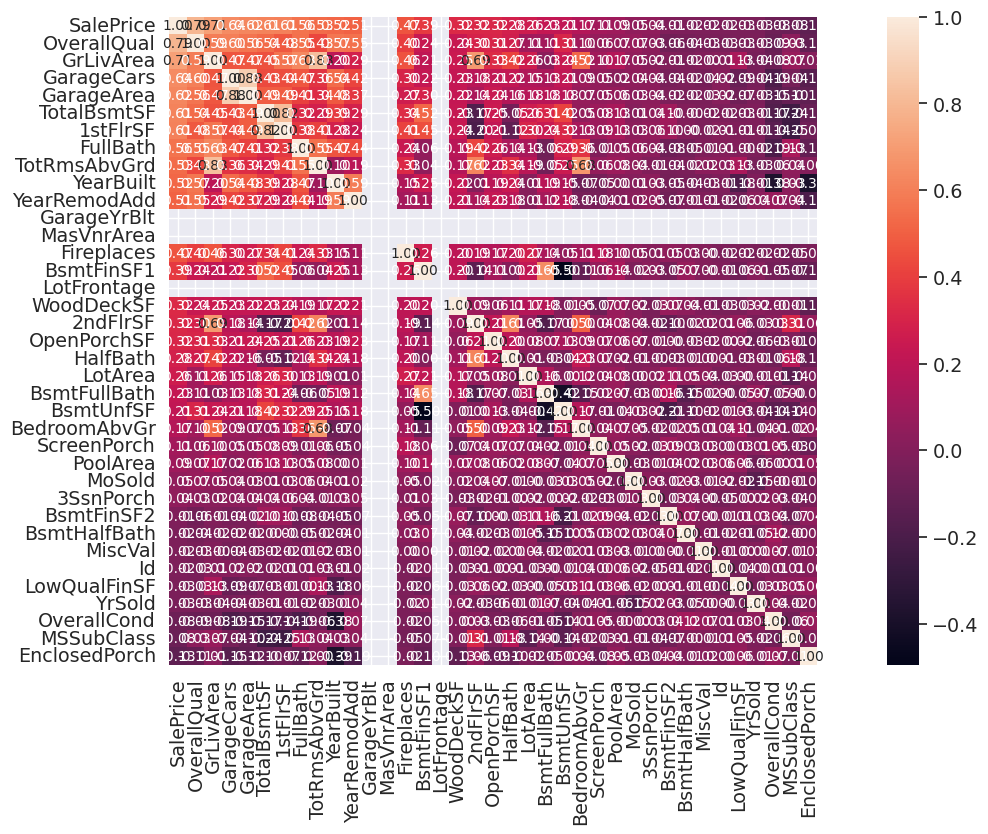

In [32]:
plots.correlation_matrix(categorical_train, k=37)

Analizziamo la heatmap:
- Sulla diagonale c'è sempre 1 perché le features sono in correlazione con loro stesse.
- La feature più importante è **OverallQual** con correlazione 0.79 rispetto al SalePrice.
- Garage Cars e Garage Area sono molto correlate tra loro, quindi si può mantenere solamente quella che è più correlata con il SalePrice, ovvero **GarageCars**.
- TotRmsAbvGrd e GrLivArea sono anche loro molto correlate tra loro, la più importante però è **GrLivArea**.
- 1stFlrSF è correlata con **TotalBsmtSF**, ma è più importante quest'ultima.